# Transformer based relationship extractor

### Dependencias

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

### Preparación, preprocesamiento y “Feature Engineering”

In [42]:
# Cargar los archivos con el separador adecuado (tabulación)
entities_df = pd.read_csv('entities_train.csv', sep='\t')
abstracts_df = pd.read_csv('abstracts_train.csv', sep='\t')
relations_df = pd.read_csv('relations_train.csv', sep='\t')

# Asegurarse de que todos los identificadores de 'abstract_id' sean strings
entities_df['abstract_id'] = entities_df['abstract_id'].astype(str)
abstracts_df['abstract_id'] = abstracts_df['abstract_id'].astype(str)
relations_df['abstract_id'] = relations_df['abstract_id'].astype(str)

# Unir los resúmenes con las relaciones usando 'abstract_id'
merged_df = pd.merge(relations_df, abstracts_df[['abstract_id', 'abstract', 'title']], on='abstract_id', how='inner')

merged_df.head()

# Guardar el DataFrame en un archivo CSV para futuros usos
# merged_df.to_csv('merged.csv', index=False)

,id,abstract_id,type,entity_1_id,entity_2_id,novel,abstract,title
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...
1,1,1353340,Positive_Correlation,rs74315458,D007966,Novel,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...
2,2,1671881,Positive_Correlation,D010661,rs62514952,Novel,Classical phenylketonuria is an autosomal rece...,Two distinct mutations at a single BamHI site ...
3,3,1671881,Positive_Correlation,D010661,rs62514953,Novel,Classical phenylketonuria is an autosomal rece...,Two distinct mutations at a single BamHI site ...
4,4,1671881,Association,5053,D010661,No,Classical phenylketonuria is an autosomal rece...,Two distinct mutations at a single BamHI site ...


In [43]:
# Unir la información de las entidades, primero para 'entity_1' y luego para 'entity_2'
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_1_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')



# Renombrar las columnas para la entidad 1
merged_df.rename(columns={'mention': 'entity_1_mention', 'type_y': 'entity_1_type'}, inplace=True)

merged_df.head()

,id,abstract_id,type_x,entity_1_id,entity_2_id,novel,abstract,title,entity_ids,entity_1_mention,entity_1_type
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct
1,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct
2,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase,GeneOrGeneProduct
3,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct
4,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,ARSA,GeneOrGeneProduct


In [44]:
merged_df.columns

Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids', 'entity_1_mention', 'entity_1_type'],
      dtype='object')

In [45]:
# Unir nuevamente con las entidades para obtener la entidad 2
merged_df = pd.merge(merged_df, entities_df[['entity_ids', 'mention', 'type', 'abstract_id']],
                     left_on=['abstract_id', 'entity_2_id'],
                     right_on=['abstract_id', 'entity_ids'],
                     how='inner')

# Renombrar las columnas para la entidad 2
merged_df.rename(columns={'mention': 'entity_2_mention', 'type': 'entity_2_type'}, inplace=True)

# Verificar el DataFrame de entrenamiento
merged_df.head()

,id,abstract_id,type_x,entity_1_id,entity_2_id,novel,abstract,title,entity_ids_x,entity_1_mention,entity_1_type,entity_ids_y,entity_2_mention,entity_2_type
0,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,metachromatic leukodystrophy,DiseaseOrPhenotypicFeature
1,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,metachromatic leukodystrophy,DiseaseOrPhenotypicFeature
2,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature
3,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature
4,0,1353340,Association,410,D007966,No,We report on a new allele at the arylsulfatase...,Late-onset metachromatic leukodystrophy: molec...,410,arylsulfatase A,GeneOrGeneProduct,D007966,MLD,DiseaseOrPhenotypicFeature


In [46]:
print("Columnas disponibles después de la fusión:", merged_df.columns)
merged_df.info()
merged_df.to_csv('merged.csv', index=False)

Columnas disponibles después de la fusión: Index(['id', 'abstract_id', 'type_x', 'entity_1_id', 'entity_2_id', 'novel',
       'abstract', 'title', 'entity_ids_x', 'entity_1_mention',
       'entity_1_type', 'entity_ids_y', 'entity_2_mention', 'entity_2_type'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73910 entries, 0 to 73909
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                73910 non-null  int64 
 1   abstract_id       73910 non-null  object
 2   type_x            73910 non-null  object
 3   entity_1_id       73910 non-null  object
 4   entity_2_id       73910 non-null  object
 5   novel             73910 non-null  object
 6   abstract          73910 non-null  object
 7   title             73910 non-null  object
 8   entity_ids_x      73910 non-null  object
 9   entity_1_mention  73910 non-null  object
 10  entity_1_type     73910 non-null  object
 11  enti

In [47]:
# Drop any potential duplicates
merged_df = merged_df.drop_duplicates()

# Retain only necessary columns for relationship extraction
merged_df = merged_df[['abstract_id', 'abstract', 'type_x', 'entity_1_mention', 'entity_2_mention', 'entity_1_type', 'entity_2_type']]

merged_df.head()


,abstract_id,abstract,type_x,entity_1_mention,entity_2_mention,entity_1_type,entity_2_type
0,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
2,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
6,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
8,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature
12,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature


In [48]:
def insert_entity_tokens(row):
    abstract = row['abstract']
    e1_mention = row['entity_1_mention']
    e2_mention = row['entity_2_mention']
    
    # Insert unique markers for each entity
    abstract = abstract.replace(e1_mention, f"[ENTITY_1]{e1_mention}[/ENTITY_1]")
    abstract = abstract.replace(e2_mention, f"[ENTITY_2]{e2_mention}[/ENTITY_2]")
    return abstract

# Apply tokenization to abstracts
merged_df['processed_abstract'] = merged_df.apply(insert_entity_tokens, axis=1)

# Verify output
print(merged_df[['processed_abstract']].head())


                                   processed_abstract
0   We report on a new allele at the [ENTITY_1]ary...
2   We report on a new allele at the [ENTITY_1]ary...
6   We report on a new allele at the arylsulfatase...
8   We report on a new allele at the arylsulfatase...
12  We report on a new allele at the [ENTITY_1]ary...


In [49]:
merged_df.head()

,abstract_id,abstract,type_x,entity_1_mention,entity_2_mention,entity_1_type,entity_2_type,processed_abstract
0,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...
2,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase A,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...
6,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the arylsulfatase...
8,1353340,We report on a new allele at the arylsulfatase...,Association,ARSA,MLD,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the arylsulfatase...
12,1353340,We report on a new allele at the arylsulfatase...,Association,arylsulfatase,metachromatic leukodystrophy,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,We report on a new allele at the [ENTITY_1]ary...


In [50]:
label_encoder = LabelEncoder()
merged_df['relationship_label'] = label_encoder.fit_transform(merged_df['type_x'])

# Save processed data to CSV
processed_data = merged_df[['processed_abstract', 'entity_1_type', 'entity_2_type', 'relationship_label']]
processed_data.head()

,processed_abstract,entity_1_type,entity_2_type,relationship_label
0,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
2,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
6,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
8,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
12,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0


In [51]:
processed_data.to_csv('processed_data.csv', index=False)

### Definición y entrenamiento de modelo

In [52]:
processed_data = pd.read_csv('processed_data.csv')
processed_data.head() # Reimportamos la información para no redundar con el preprocesamiento

,processed_abstract,entity_1_type,entity_2_type,relationship_label
0,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
1,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
2,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
3,We report on a new allele at the arylsulfatase...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0
4,We report on a new allele at the [ENTITY_1]ary...,GeneOrGeneProduct,DiseaseOrPhenotypicFeature,0


In [53]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))

def tokenize_data(examples):
    return tokenizer(examples['processed_abstract'], padding="max_length", truncation=True)

# Apply tokenization to the whole dataset
# tokenized_data = processed_data.apply(lambda row: tokenize_data(row), axis=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
X = processed_data['processed_abstract']
y = processed_data['relationship_label']

# Split the data into training and evaluation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [55]:
# Define max sequence length for BERT input
maxlen = 200

# Tokenize training data
train_encodings = tokenizer(
    X_train.tolist(), # Convert to list for batch tokenization
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

# Tokenize testing data
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding="max_length",
    max_length=maxlen
)

In [56]:
class RelationshipDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert to torch Dataset objects
train_dataset = RelationshipDataset(train_encodings, y_train.tolist())
test_dataset = RelationshipDataset(test_encodings, y_test.tolist())


In [57]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [59]:
torch.cuda.is_available()

True

In [58]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example of creating a tensor on the GPU
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)

# Move your model to the GPU
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [60]:

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',           # Output directory for checkpoints
    evaluation_strategy="epoch",      # Evaluate at each epoch end
    per_device_train_batch_size=8,    # Batch size for training
    per_device_eval_batch_size=8,     # Batch size for evaluation
    num_train_epochs=3,               # Total number of training epochs
    learning_rate=2e-5,               # Learning rate
    logging_dir='./logs',             # Directory for storing logs
    save_strategy='epoch',
    load_best_model_at_end=True       # Load best model after training
)

# Initialize Trainer with model, arguments, dataset, and metrics
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [61]:
# Train the model
trainer.train()

  0%|          | 0/3360 [00:00<?, ?it/s]

{'loss': 1.0207, 'grad_norm': 5.882041931152344, 'learning_rate': 1.7023809523809524e-05, 'epoch': 0.45}
{'loss': 0.8371, 'grad_norm': 13.211043357849121, 'learning_rate': 1.4047619047619048e-05, 'epoch': 0.89}


  0%|          | 0/280 [00:00<?, ?it/s]

c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.7201603651046753, 'eval_accuracy': 0.7373827601607861, 'eval_f1': 0.7226378399643775, 'eval_precision': 0.7236088411236242, 'eval_recall': 0.7373827601607861, 'eval_runtime': 95.4102, 'eval_samples_per_second': 23.467, 'eval_steps_per_second': 2.935, 'epoch': 1.0}
{'loss': 0.7041, 'grad_norm': 12.569625854492188, 'learning_rate': 1.1071428571428572e-05, 'epoch': 1.34}
{'loss': 0.6607, 'grad_norm': 11.485201835632324, 'learning_rate': 8.095238095238097e-06, 'epoch': 1.79}


  0%|          | 0/280 [00:00<?, ?it/s]

c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6477283835411072, 'eval_accuracy': 0.7650736936132202, 'eval_f1': 0.7580707675301982, 'eval_precision': 0.7606313113227039, 'eval_recall': 0.7650736936132202, 'eval_runtime': 95.5999, 'eval_samples_per_second': 23.421, 'eval_steps_per_second': 2.929, 'epoch': 2.0}
{'loss': 0.5684, 'grad_norm': 11.84036922454834, 'learning_rate': 5.119047619047619e-06, 'epoch': 2.23}
{'loss': 0.4879, 'grad_norm': 9.749794960021973, 'learning_rate': 2.1428571428571427e-06, 'epoch': 2.68}


  0%|          | 0/280 [00:00<?, ?it/s]

c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 0.6246736645698547, 'eval_accuracy': 0.7869584635998214, 'eval_f1': 0.7768094080516753, 'eval_precision': 0.7688506085439327, 'eval_recall': 0.7869584635998214, 'eval_runtime': 92.0256, 'eval_samples_per_second': 24.33, 'eval_steps_per_second': 3.043, 'epoch': 3.0}
{'train_runtime': 3579.1134, 'train_samples_per_second': 7.505, 'train_steps_per_second': 0.939, 'train_loss': 0.6915263539268857, 'epoch': 3.0}


TrainOutput(global_step=3360, training_loss=0.6915263539268857, metrics={'train_runtime': 3579.1134, 'train_samples_per_second': 7.505, 'train_steps_per_second': 0.939, 'total_flos': 2760964811193600.0, 'train_loss': 0.6915263539268857, 'epoch': 3.0})

In [62]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

  0%|          | 0/280 [00:00<?, ?it/s]

Evaluation Results: {'eval_loss': 0.6246736645698547, 'eval_accuracy': 0.7869584635998214, 'eval_f1': 0.7768094080516753, 'eval_precision': 0.7688506085439327, 'eval_recall': 0.7869584635998214, 'eval_runtime': 78.3762, 'eval_samples_per_second': 28.567, 'eval_steps_per_second': 3.573, 'epoch': 3.0}


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualización de resultados

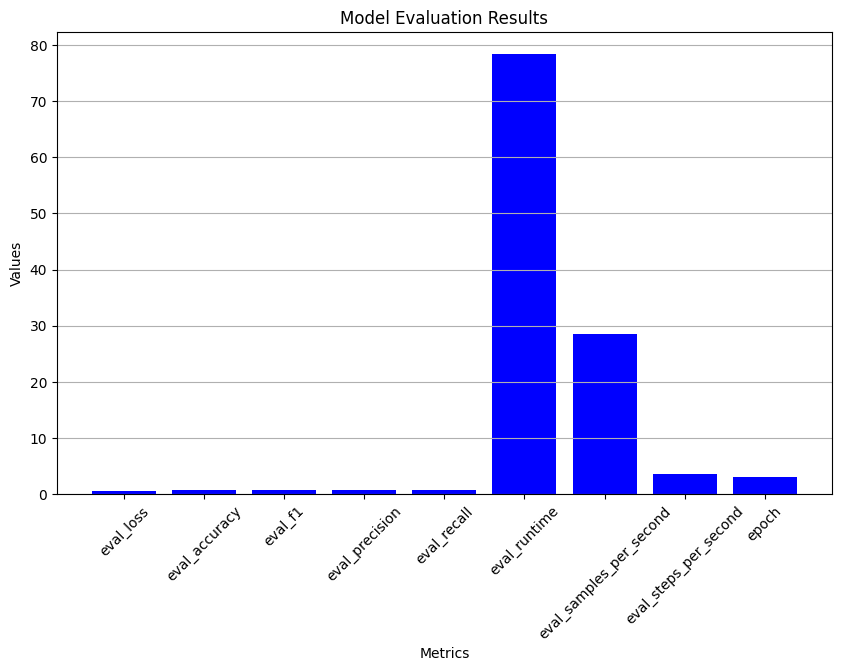

In [63]:
# Extract metrics
metrics = eval_results.keys()
values = eval_results.values()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color='blue')
plt.title('Model Evaluation Results')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.show()

In [65]:
model.save_pretrained('./relationship_model')
tokenizer.save_pretrained('./relationship_model')
pd.to_pickle(label_encoder, './relationship_model/label_encoder.pkl')